W207: Final Project
===========

Our team (Danish Iqbal, KC Tobin, Jason Vantomme) is working through the Kaggle "House Prices: Advanced Regression Techniques" competition @ https://www.kaggle.com/c/house-prices-advanced-regression-techniques.

Our first step is to scrub the data and generate effective features from what is provided.  We have divided this process into three parts, one for each team member.

In [38]:
# ENVIRONMENT SETUP

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import datetime
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model as lm
from sklearn import preprocessing
from sklearn import metrics

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None) 

In [2]:
# LOAD THE PROVIDED TRAINING DATA AND DO BASIC ASSESSMENTS
original_train_data = pd.read_csv('data/train.csv',delimiter=',',header=0)
print original_train_data.describe()

                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726   
std       1.112799    30.202904     20.645407   181.066207   456.098091   
min       1.000

In [33]:
# Find missing values, types , and value counts for each column that is not continous. This will help with
# picking dummy values and thresholds for splitting variables
columns = original_train_data.loc[:]
for i in columns:
    if (original_train_data[i].dtype != 'float64'):
        print '---- ', i,'-----'
        print 'Missing values: ', original_train_data[i].isnull().sum()
        print 'is of type: ', original_train_data[i].dtype
        print original_train_data[i].value_counts()

----  Id -----
Missing values:  0
is of type:  int64
1460    1
479     1
481     1
482     1
483     1
484     1
485     1
486     1
487     1
488     1
489     1
490     1
491     1
492     1
493     1
494     1
495     1
496     1
497     1
498     1
499     1
480     1
478     1
501     1
477     1
458     1
459     1
460     1
461     1
462     1
       ..
996     1
997     1
998     1
999     1
1000    1
1001    1
1002    1
983     1
982     1
981     1
970     1
962     1
963     1
964     1
965     1
966     1
967     1
968     1
969     1
971     1
980     1
972     1
973     1
974     1
975     1
976     1
977     1
978     1
979     1
1       1
Name: Id, dtype: int64
----  MSSubClass -----
Missing values:  0
is of type:  int64
20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64
----  MSZoning -----
Missing values:  0
is of type:  obje

TypeError: scatter() takes at least 2 arguments (1 given)

In [3]:
# CONTINUE ASSESSMENTS; ANY STRONG CORRELATIONS BETWEEN FEATURES?
corr = original_train_data.corr()
print corr
#features highly correlated to SalePrice include and are of interest:
#OverallQual, YearBuilt, 1stFlrSF, GrLivArea, FullBath, GarageCars

                     Id  MSSubClass  LotFrontage   LotArea  OverallQual  \
Id             1.000000    0.011156    -0.010601 -0.033226    -0.028365   
MSSubClass     0.011156    1.000000    -0.386347 -0.139781     0.032628   
LotFrontage   -0.010601   -0.386347     1.000000  0.426095     0.251646   
LotArea       -0.033226   -0.139781     0.426095  1.000000     0.105806   
OverallQual   -0.028365    0.032628     0.251646  0.105806     1.000000   
OverallCond    0.012609   -0.059316    -0.059213 -0.005636    -0.091932   
YearBuilt     -0.012713    0.027850     0.123349  0.014228     0.572323   
YearRemodAdd  -0.021998    0.040581     0.088866  0.013788     0.550684   
MasVnrArea    -0.050298    0.022936     0.193458  0.104160     0.411876   
BsmtFinSF1    -0.005024   -0.069836     0.233633  0.214103     0.239666   
BsmtFinSF2    -0.005968   -0.065649     0.049900  0.111170    -0.059119   
BsmtUnfSF     -0.007940   -0.140759     0.132644 -0.002618     0.308159   
TotalBsmtSF   -0.015415  

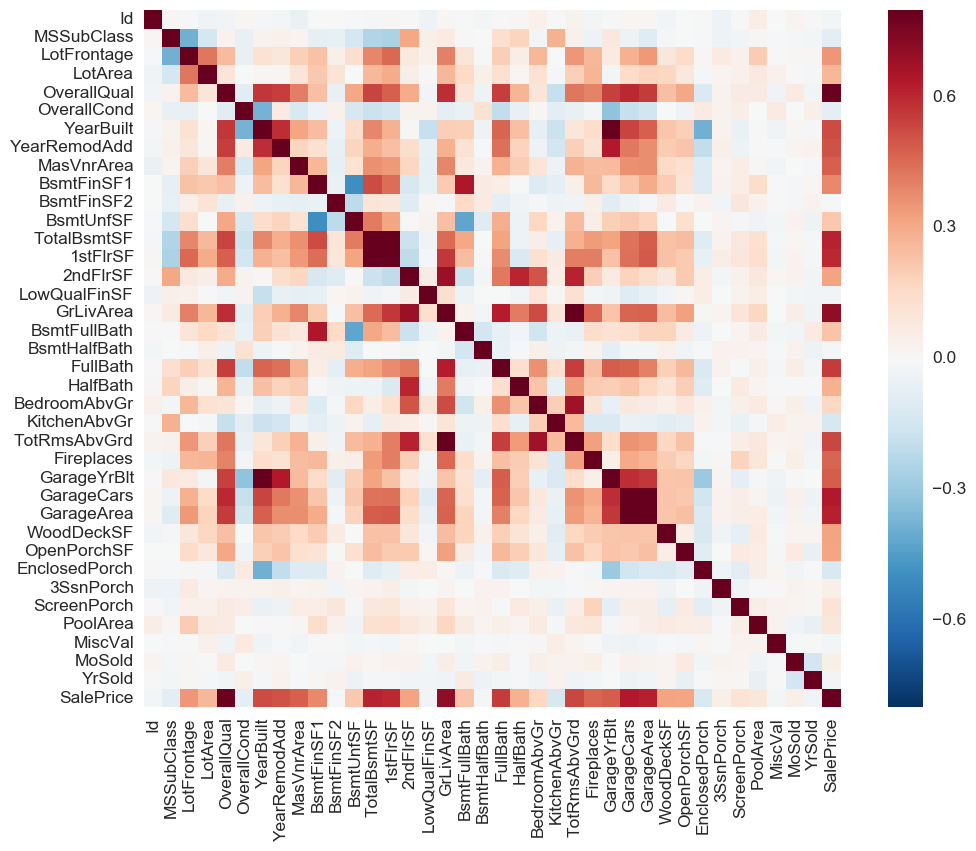

In [24]:
#creating correlation matrix for better visibiilty of plots
corrmat = original_train_data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [ ]:
#features highly correlated to SalePrice include and are of interest:
#OverallQual, YearBuilt, 1stFlrSF, GrLivArea, FullBath, GarageCars

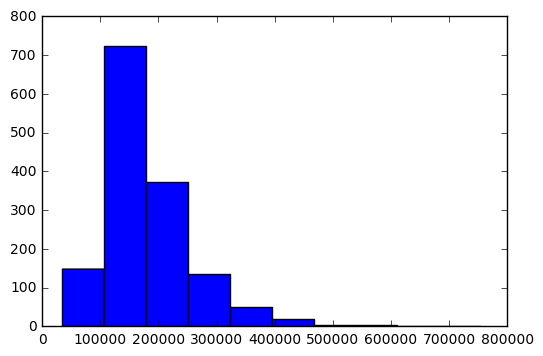

In [5]:
# plot dependent variable, sales prices to see how it's distributed. Then plot correlations w. highly correlated variables
plt.hist(original_train_data['SalePrice']);

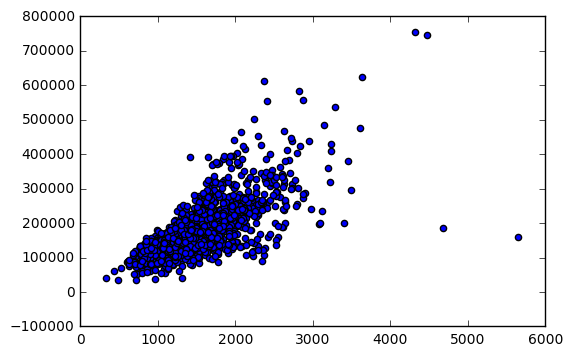

In [11]:
plt.scatter(x=original_train_data['GrLivArea'], y=original_train_data['SalePrice'])
# keep variable as continous. There are 2 outliers, but may be best to keep them

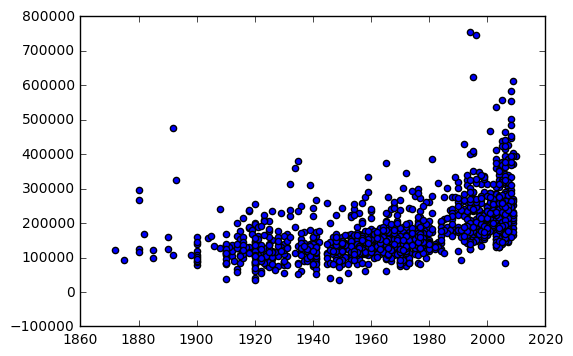

In [12]:
plt.scatter(x=original_train_data['YearBuilt'], y=original_train_data['SalePrice'])
# split into decades as there seems to be some clustering around decades

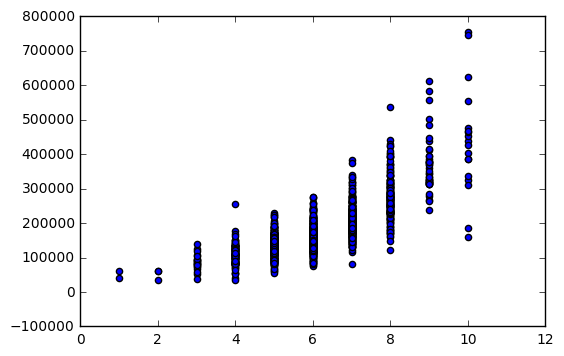

In [13]:
plt.scatter(x=original_train_data['OverallQual'], y=original_train_data['SalePrice'])
#overall positive trend, split into dummy variables for each.

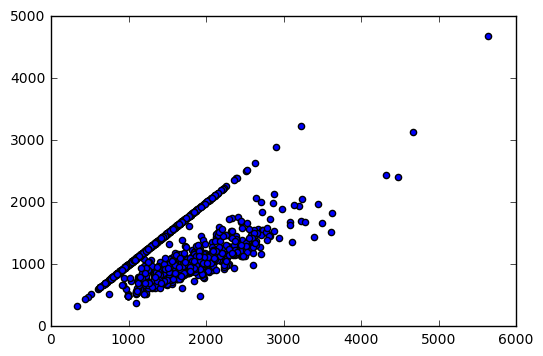

In [17]:
plt.scatter(x=original_train_data['GrLivArea'], y=original_train_data['1stFlrSF'])
#there is high correlation between these two variables. Need to be careful when interperting result in a regression as 
#there is high multicollinearity between these two

In [39]:
# Plotting categorical variables to see what ranges to put them into 
#plt.hist(original_train_data['MSSubClass'], bins=range(20,190, 5)) #20, 60, 50, 120, 80, 160, 90, 30, 70, all else
#plt.hist(original_train_data['MSZoning'], bins=range(20,190, 5)) #
#original_train_data.LotFrontage.value_counts().plot(kind='bar') 
#plt.hist(original_train_data['LotFrontage'], bins=range(0,300, 10)) #None, below 50, 60, 70, 80, 90 and above
#original_train_data.HouseStyle.value_counts().plot(kind='bar')#1 story, 2 story, 1.5 finished, slevel, other
#plt.hist(original_train_data['LotArea'], bins=range(20,30000, 1000)) #below 5K, then 1K for each till 14K, then above 
#plt.hist(original_train_data['YearBuilt'], bins=range(1927,2005, 1)) # group by decade
#original_train_data.Neighborhood.value_counts().plot(kind='bar')# if below 20, then other
#original_train_data.Exterior1st.value_counts().plot(kind='bar')# vinly, hdbrd, mtlsd,wdsdng, plywood, other
#original_train_data.Exterior2nd.value_counts().plot(kind='bar')# same variable as exerioro1st
#plt.hist(original_train_data['YearBuilt'], bins=range(1927,2005, 1)) # group by decade
#plt.hist(original_train_data['YearRemodAdd'])# group by decade